In [ ]:
%pip install pandas numpy nltk textblob scikit-learn matplotlib seaborn wordcloud vaderSentiment psutil -q


Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import json
import warnings
import gc
import sys
import os
import time
import psutil  # For memory monitoring

warnings.filterwarnings('ignore')

# Set memory limits to prevent crashes
try:
    process = psutil.Process(os.getpid())
    mem_info = process.memory_info()
    print(f"Initial memory usage: {mem_info.rss / 1024 / 1024:.1f} MB")
except:
    pass  # psutil not available, continue anyway

# Configure matplotlib to prevent memory issues
%matplotlib inline
plt.ioff()  # Turn off interactive mode to prevent memory issues

# Clear any existing figures from previous runs
try:
    plt.close('all')
except:
    pass

plt.style.use('default')
sns.set_palette("husl")

# Force garbage collection to clear any lingering state
gc.collect()

# Pre-download NLTK data with error handling and checks
try:
    import nltk
    
    # Set NLTK data directory
    nltk_data_dir = os.path.join(os.path.expanduser('~'), 'nltk_data')
    os.makedirs(nltk_data_dir, exist_ok=True)
    
    # Helper function to safely check and download NLTK data
    def safe_nltk_download(resource_name):
        """Safely download NLTK resource with checks."""
        try:
            # Check if already downloaded
            try:
                nltk.data.find(f'tokenizers/{resource_name}')
                return True  # Already exists
            except LookupError:
                pass
            
            try:
                nltk.data.find(f'corpora/{resource_name}')
                return True  # Already exists
            except LookupError:
                pass
            
            # Try to download
            nltk.download(resource_name, quiet=True, raise_on_error=False)
            time.sleep(0.1)  # Small delay to prevent race conditions
            return True
        except Exception as e:
            print(f"Warning: {resource_name} download issue: {e}")
            return False
    
    # Download NLTK resources with safety checks
    print("Checking NLTK data...")
    safe_nltk_download('punkt')
    safe_nltk_download('stopwords')
    safe_nltk_download('wordnet')
    safe_nltk_download('omw-1.4')
    print("✓ NLTK data ready")
        
except Exception as e:
    print(f"Warning: NLTK initialization issue: {e}")
    print("Continuing anyway...")

# Import custom modules with error handling and delays
# Add small delays to prevent initialization race conditions
time.sleep(0.2)  # Small delay before importing modules

try:
    from sentiment_analyzer import SentimentAnalyzer
    print("✓ SentimentAnalyzer imported")
except Exception as e:
    print(f"❌ Error importing SentimentAnalyzer: {e}")
    import traceback
    traceback.print_exc()
    raise  # Re-raise to stop execution

time.sleep(0.1)  # Small delay between imports

try:
    from word_analyzer import WordAnalyzer
    print("✓ WordAnalyzer imported")
except Exception as e:
    print(f"❌ Error importing WordAnalyzer: {e}")
    import traceback
    traceback.print_exc()
    raise  # Re-raise to stop execution

time.sleep(0.1)  # Small delay between imports

try:
    from theme_extractor import ThemeExtractor
    print("✓ ThemeExtractor imported")
except Exception as e:
    print(f"❌ Error importing ThemeExtractor: {e}")
    import traceback
    traceback.print_exc()
    raise  # Re-raise to stop execution

print("✓ All imports successful")


Initial memory usage: 192.7 MB
Checking NLTK data...
✓ NLTK data ready
✓ SentimentAnalyzer imported
✓ WordAnalyzer imported
✓ ThemeExtractor imported
✓ All imports successful


In [ ]:
DATA_FILE = "yelp_academic_dataset_review.json"
SAMPLE_SIZE = 5000

try:
    import os
    if not os.path.exists(DATA_FILE):
        raise FileNotFoundError(f"Data file '{DATA_FILE}' not found. Please ensure the file exists in the current directory.")
    
    print(f"Loading {SAMPLE_SIZE} reviews from {DATA_FILE}...")
    reviews = []
    with open(DATA_FILE, 'r', encoding='utf-8') as f:
        for i, line in enumerate(f):
            if len(reviews) >= SAMPLE_SIZE:
                break
            try:
                reviews.append(json.loads(line))
            except json.JSONDecodeError:
                continue
            except MemoryError:
                print(f"Memory error at line {i+1}. Stopping early with {len(reviews)} reviews.")
                break
            if (i + 1) % 1000 == 0:
                print(f"  Loaded {len(reviews)} reviews...")
                gc.collect()  # Periodic garbage collection during loading
    
    df = pd.DataFrame(reviews)
    del reviews  # Free memory after creating DataFrame
    gc.collect()
    text_column = 'text'
    print(f"✓ Successfully loaded {len(df)} reviews")
    print(f"  Columns: {list(df.columns)}")
except Exception as e:
    print(f"Error loading data: {e}")
    import traceback
    traceback.print_exc()
    gc.collect()
    raise


Loading 5000 reviews from yelp_academic_dataset_review.json...
  Loaded 1000 reviews...
  Loaded 2000 reviews...
  Loaded 3000 reviews...
  Loaded 4000 reviews...
  Loaded 5000 reviews...
✓ Successfully loaded 5000 reviews
  Columns: ['review_id', 'user_id', 'business_id', 'stars', 'useful', 'funny', 'cool', 'text', 'date']


Analyzing sentiment...

Sentiment Distribution:
  Positive: 4352 (87.0%)
  Negative: 588 (11.8%)
  Neutral: 60 (1.2%)

✓ Sentiment analysis complete


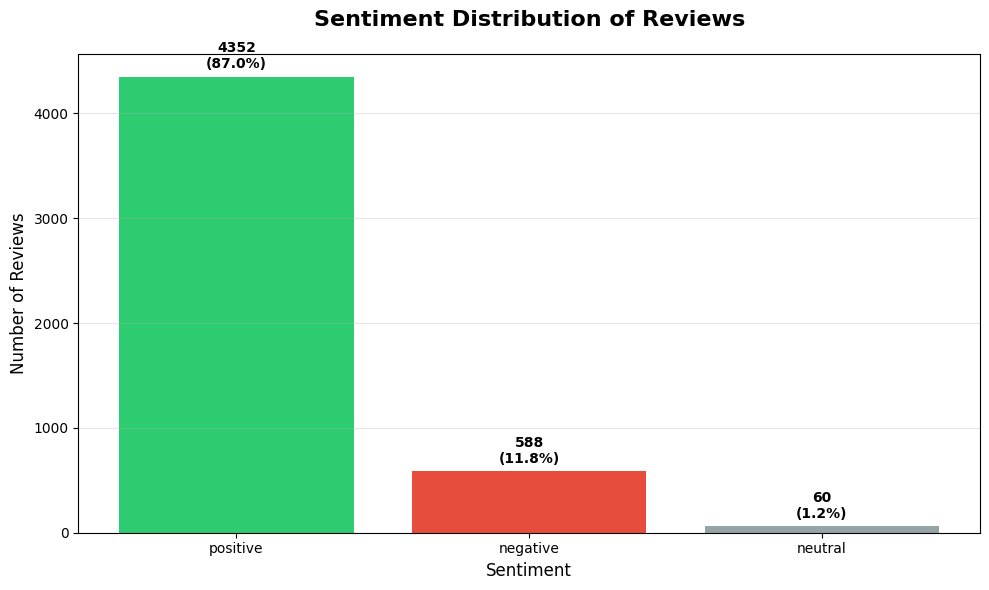

12

In [ ]:
sentiment_analyzer = SentimentAnalyzer()
df = sentiment_analyzer.analyze_reviews(df, text_column=text_column, method='vader')
sentiment_counts = df['sentiment'].value_counts()
fig, ax = plt.subplots(figsize=(10, 6))
colors = ['#2ecc71', '#e74c3c', '#95a5a6']
bars = ax.bar(sentiment_counts.index, sentiment_counts.values, color=colors)
total = len(df)
for bar, count in zip(bars, sentiment_counts.values):
    height = bar.get_height()
    percentage = (count / total) * 100
    ax.text(bar.get_x() + bar.get_width()/2., height + total*0.01,
             f'{count}\n({percentage:.1f}%)',
             ha='center', va='bottom', fontweight='bold')
ax.set_title('Sentiment Distribution of Reviews', fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Sentiment', fontsize=12)
ax.set_ylabel('Number of Reviews', fontsize=12)
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()
plt.close(fig)  # Close figure to free memory
gc.collect()  # Force garbage collection


Analyzing 4352 positive reviews...
  Analyzing 1000 reviews...
  Analyzing 1000 reviews...
  Analyzing 1000 reviews...
  Analyzing 1000 reviews...
  Analyzing 352 reviews...
Analyzing 588 negative reviews...
  Analyzing 588 reviews...


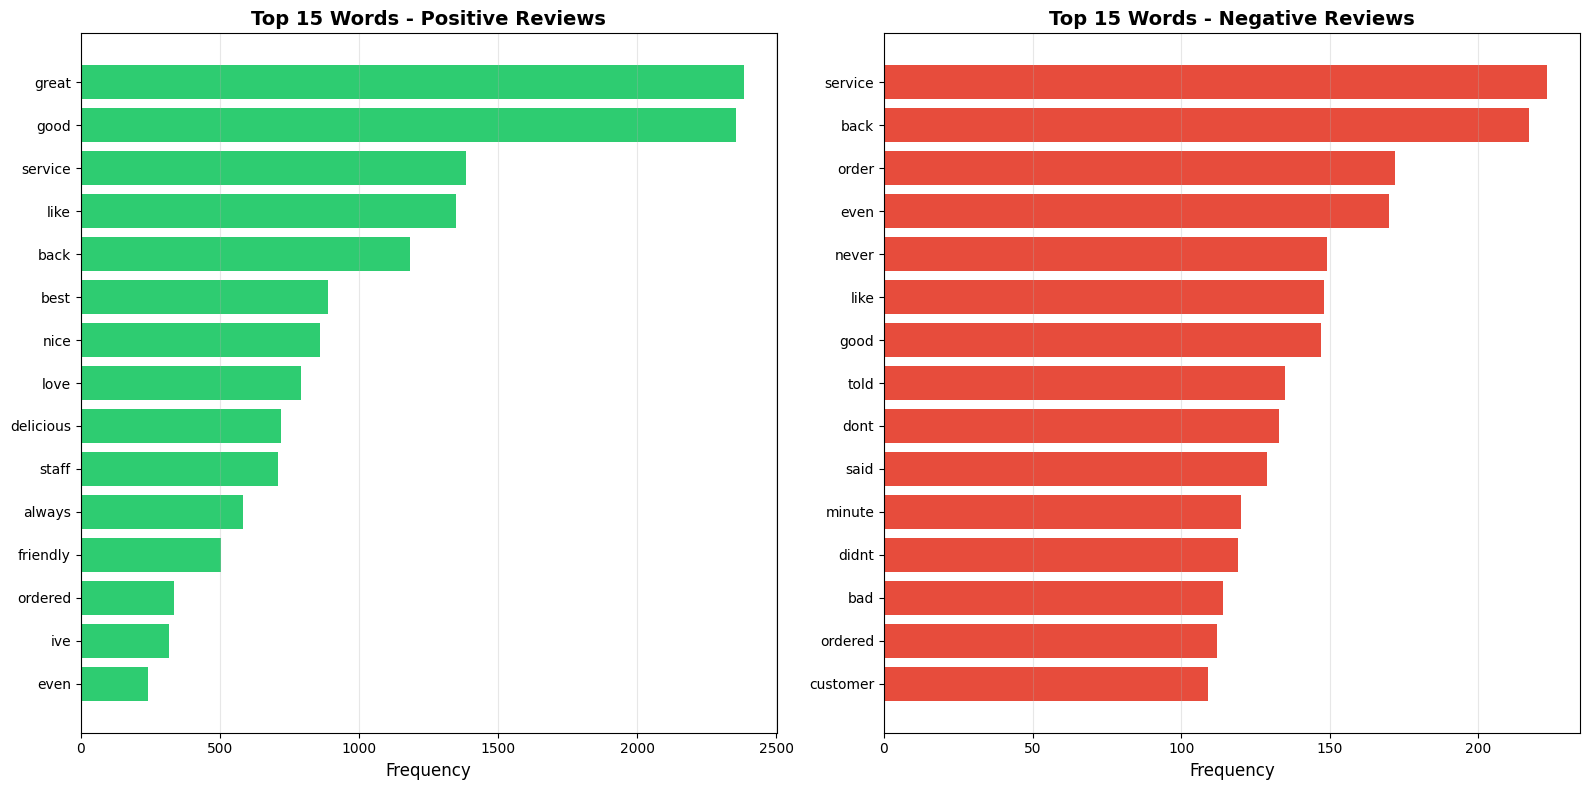

✓ Word frequency analysis complete


In [ ]:
try:
    word_analyzer = WordAnalyzer()
    positive_texts = df[df['sentiment'] == 'positive']['cleaned_text']
    negative_texts = df[df['sentiment'] == 'negative']['cleaned_text']
    
    # Process in batches to prevent memory issues
    print(f"Analyzing {len(positive_texts)} positive reviews...")
    # Process positive texts in smaller chunks
    batch_size = 1000
    top_positive_words = None
    for i in range(0, len(positive_texts), batch_size):
        batch = positive_texts.iloc[i:i+batch_size]
        batch_words = word_analyzer.get_top_words(batch, top_n=15)
        if top_positive_words is None:
            top_positive_words = dict(batch_words)
        else:
            # Merge counts
            for word, count in batch_words:
                top_positive_words[word] = top_positive_words.get(word, 0) + count
        gc.collect()  # Clean up after each batch
    
    # Sort and get top 15
    top_positive_words = sorted(top_positive_words.items(), key=lambda x: x[1], reverse=True)[:15]
    
    print(f"Analyzing {len(negative_texts)} negative reviews...")
    # Process negative texts in smaller chunks
    top_negative_words = None
    for i in range(0, len(negative_texts), batch_size):
        batch = negative_texts.iloc[i:i+batch_size]
        batch_words = word_analyzer.get_top_words(batch, top_n=15)
        if top_negative_words is None:
            top_negative_words = dict(batch_words)
        else:
            # Merge counts
            for word, count in batch_words:
                top_negative_words[word] = top_negative_words.get(word, 0) + count
        gc.collect()  # Clean up after each batch
    
    # Sort and get top 15
    top_negative_words = sorted(top_negative_words.items(), key=lambda x: x[1], reverse=True)[:15]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    pos_words = dict(top_positive_words[:15])
    ax1.barh(range(len(pos_words)), list(pos_words.values()), color='#2ecc71')
    ax1.set_yticks(range(len(pos_words)))
    ax1.set_yticklabels(list(pos_words.keys()))
    ax1.set_xlabel('Frequency', fontsize=12)
    ax1.set_title('Top 15 Words - Positive Reviews', fontsize=14, fontweight='bold')
    ax1.invert_yaxis()
    ax1.grid(axis='x', alpha=0.3)
    
    neg_words = dict(top_negative_words[:15])
    ax2.barh(range(len(neg_words)), list(neg_words.values()), color='#e74c3c')
    ax2.set_yticks(range(len(neg_words)))
    ax2.set_yticklabels(list(neg_words.keys()))
    ax2.set_xlabel('Frequency', fontsize=12)
    ax2.set_title('Top 15 Words - Negative Reviews', fontsize=14, fontweight='bold')
    ax2.invert_yaxis()
    ax2.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    plt.close(fig)  # Close figure to free memory
    del top_positive_words, top_negative_words, pos_words, neg_words
    gc.collect()  # Force garbage collection
    print("✓ Word frequency analysis complete")
except Exception as e:
    print(f"Error in word frequency analysis: {e}")
    import traceback
    traceback.print_exc()
    gc.collect()


Generating positive word cloud from 1500 reviews...


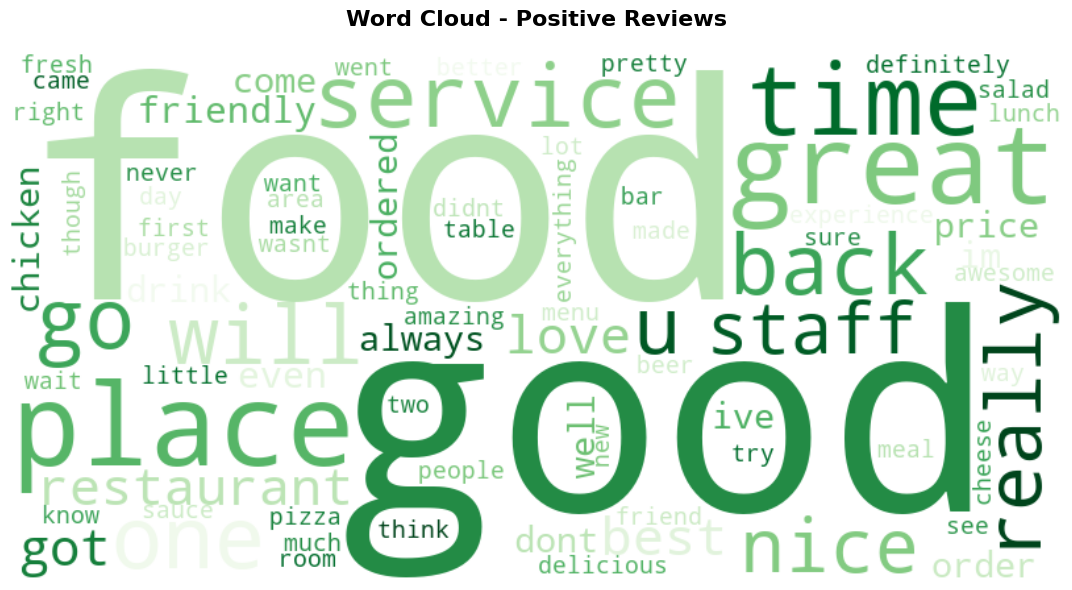

Generating negative word cloud from 588 reviews...


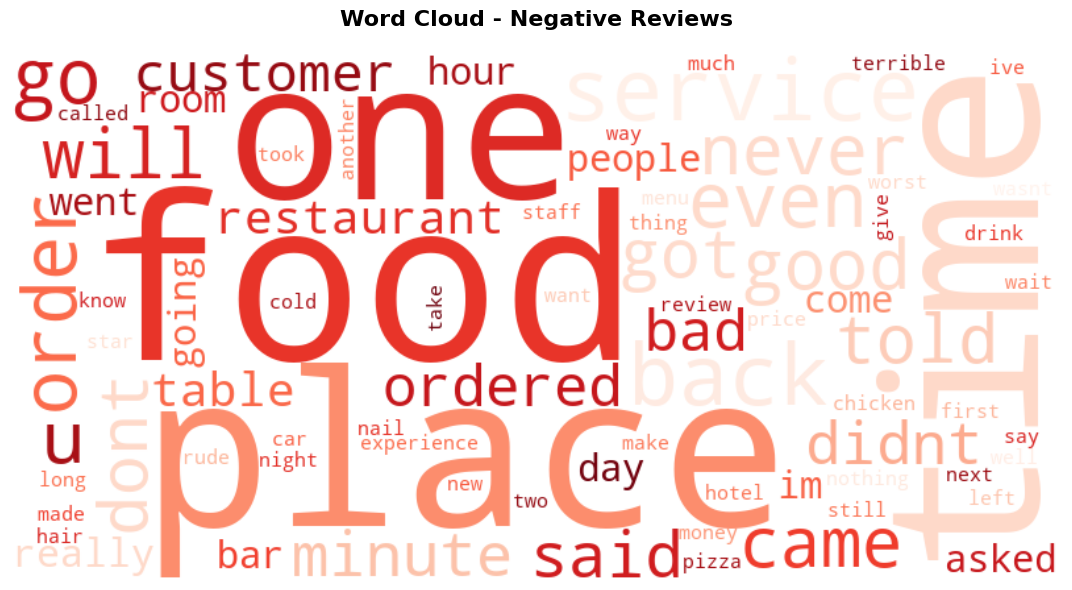

In [ ]:
# Optimized WordCloud generation to prevent memory issues
# Limit text size and use efficient processing
try:
    # Sample text to avoid memory issues (use first 1500 reviews max)
    max_reviews_for_cloud = 1500
    positive_sample = positive_texts.head(max_reviews_for_cloud) if len(positive_texts) > max_reviews_for_cloud else positive_texts
    
    # Use more efficient string concatenation
    positive_text_list = positive_sample.astype(str).tolist()
    positive_text = ' '.join(positive_text_list)
    del positive_text_list  # Free memory immediately
    
    # Limit text length to prevent memory overflow
    max_text_length = 400000  # ~400KB of text
    if len(positive_text) > max_text_length:
        positive_text = positive_text[:max_text_length]
    
    if positive_text.strip():
        print(f"Generating positive word cloud from {len(positive_sample)} reviews...")
        wordcloud_pos = WordCloud(
            width=800, 
            height=400, 
            background_color='white',
            colormap='Greens',
            max_words=80,  # Reduced from 100 to save memory
            relative_scaling=0.5,
            collocations=False,  # Disable bigram collocations to save memory
            random_state=42  # Fixed seed for identical visual layouts
        ).generate(positive_text)
        fig_pos = plt.figure(figsize=(12, 6))
        plt.imshow(wordcloud_pos, interpolation='bilinear')
        plt.axis('off')
        plt.title('Word Cloud - Positive Reviews', fontsize=16, fontweight='bold', pad=20)
        plt.tight_layout()
        plt.show()
        plt.close(fig_pos)  # Close figure immediately
        del wordcloud_pos, positive_text, positive_sample  # Free memory
        gc.collect()  # Force garbage collection
    else:
        print("No positive text available for word cloud")
except Exception as e:
    print(f"Error generating positive word cloud: {e}")
    import traceback
    traceback.print_exc()
    gc.collect()

try:
    # Sample text to avoid memory issues
    negative_sample = negative_texts.head(max_reviews_for_cloud) if len(negative_texts) > max_reviews_for_cloud else negative_texts
    
    # Use more efficient string concatenation
    negative_text_list = negative_sample.astype(str).tolist()
    negative_text = ' '.join(negative_text_list)
    del negative_text_list  # Free memory immediately
    
    # Limit text length
    if len(negative_text) > max_text_length:
        negative_text = negative_text[:max_text_length]
    
    if negative_text.strip():
        print(f"Generating negative word cloud from {len(negative_sample)} reviews...")
        wordcloud_neg = WordCloud(
            width=800, 
            height=400, 
            background_color='white',
            colormap='Reds',
            max_words=80,  # Reduced from 100 to save memory
            relative_scaling=0.5,
            collocations=False,  # Disable bigram collocations to save memory
            random_state=42  # Fixed seed for identical visual layouts
        ).generate(negative_text)
        fig_neg = plt.figure(figsize=(12, 6))
        plt.imshow(wordcloud_neg, interpolation='bilinear')
        plt.axis('off')
        plt.title('Word Cloud - Negative Reviews', fontsize=16, fontweight='bold', pad=20)
        plt.tight_layout()
        plt.show()
        plt.close(fig_neg)  # Close figure immediately
        del wordcloud_neg, negative_text, negative_sample  # Free memory
        gc.collect()  # Force garbage collection
    else:
        print("No negative text available for word cloud")
except Exception as e:
    print(f"Error generating negative word cloud: {e}")
    import traceback
    traceback.print_exc()
    gc.collect()


Extracting themes...

✓ Theme extraction complete
🎯 THEME INSIGHTS:

SERVICE:
  Positive reviews: 56.5% mention this theme
  Negative reviews: 55.1% mention this theme
  Difference: +1.4% (more in positive)

FOOD QUALITY:
  Positive reviews: 47.5% mention this theme
  Negative reviews: 37.2% mention this theme
  Difference: +10.3% (more in positive)

AMBIANCE:
  Positive reviews: 28.9% mention this theme
  Negative reviews: 17.3% mention this theme
  Difference: +11.5% (more in positive)

PRICE VALUE:
  Positive reviews: 31.8% mention this theme
  Negative reviews: 32.5% mention this theme
  Difference: -0.7% (more in negative)

WAIT TIME:
  Positive reviews: 56.0% mention this theme
  Negative reviews: 62.6% mention this theme
  Difference: -6.5% (more in negative)

LOCATION:
  Positive reviews: 23.7% mention this theme
  Negative reviews: 20.9% mention this theme
  Difference: +2.8% (more in positive)

CROWDEDNESS:
  Positive reviews: 35.5% mention this theme
  Negative reviews: 40.3

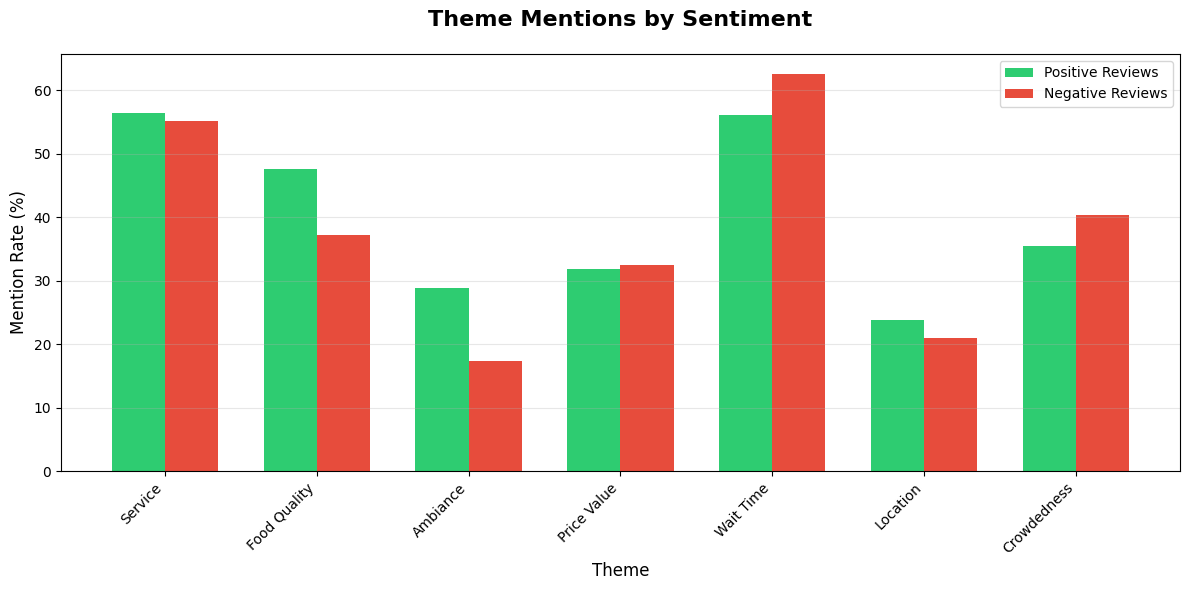

✓ Theme analysis chart generated


In [ ]:
try:
    theme_extractor = ThemeExtractor()
    df = theme_extractor.extract_themes_from_reviews(df)
    theme_insights = theme_extractor.get_theme_insights(df)
    
    themes = list(theme_insights.keys())
    pos_rates = [theme_insights[t]['positive_mention_rate'] for t in themes]
    neg_rates = [theme_insights[t]['negative_mention_rate'] for t in themes]
    
    x = np.arange(len(themes))
    width = 0.35
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.bar(x - width/2, pos_rates, width, label='Positive Reviews', color='#2ecc71')
    ax.bar(x + width/2, neg_rates, width, label='Negative Reviews', color='#e74c3c')
    ax.set_xlabel('Theme', fontsize=12)
    ax.set_ylabel('Mention Rate (%)', fontsize=12)
    ax.set_title('Theme Mentions by Sentiment', fontsize=16, fontweight='bold', pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels([t.replace('_', ' ').title() for t in themes], rotation=45, ha='right')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
    plt.close(fig)  # Close figure to free memory
    gc.collect()  # Force garbage collection
    print("✓ Theme analysis chart generated")
except Exception as e:
    print(f"Error in theme analysis: {e}")
    import traceback
    traceback.print_exc()
    gc.collect()


In [ ]:
# Final cleanup to free memory
plt.close('all')  # Close all remaining figures
gc.collect()  # Final garbage collection
print("✓ Memory cleanup complete")


✓ Memory cleanup complete
